# Plot limits:

In [1]:
import os, sys
import json
import matplotlib.pyplot as plt
import ROOT
print('Modules loaded.')

Welcome to JupyROOT 6.26/10
Modules loaded.


### Preparing the dataframe

In [2]:
with open("VLL_limits.json", "r") as f: vll_limits = json.load(f)
with open("sigdata.json", "r") as f: sig_data = json.load(f)

# Initialize the new dictionary
combined_results = {}

# Iterate through each entry in VLLlimits and add corresponding xsec and nGenerated from sig_data
for model, limits in vll_limits.items():
    # Extract the base name (e.g., "VLLD_ele_M100") and look up the xsec and nGenerated values
    model_base = model.replace("datacard_", "")
    if model_base in sig_data:
        combined_results[model_base] = {
            **limits, 
            "xsec": sig_data[model_base]["xsec"],
            "nGenerated": sig_data[model_base]["nGenerated"]
        }

# Print the combined results
print(json.dumps(combined_results, indent=2))

{
  "VLLD_ele_M100": {
    "Observed Limit": 2.0061,
    "Expected  2.5%": 0.0324,
    "Expected 16.0%": 0.0432,
    "Expected 50.0%": 0.0601,
    "Expected 84.0%": 0.0826,
    "Expected 97.5%": 0.1099,
    "xsec": 16.9,
    "nGenerated": 110871
  },
  "VLLD_ele_M1000": {
    "Observed Limit": 98.8839,
    "Expected  2.5%": 59.0186,
    "Expected 16.0%": 75.4699,
    "Expected 50.0%": 98.75,
    "Expected 84.0%": 126.6971,
    "Expected 97.5%": 153.8201,
    "xsec": 0.000971,
    "nGenerated": 24286
  },
  "VLLD_ele_M200": {
    "Observed Limit": 0.1574,
    "Expected  2.5%": 0.0854,
    "Expected 16.0%": 0.1134,
    "Expected 50.0%": 0.1572,
    "Expected 84.0%": 0.218,
    "Expected 97.5%": 0.2902,
    "xsec": 1.36,
    "nGenerated": 73730
  },
  "VLLD_ele_M300": {
    "Observed Limit": 0.4724,
    "Expected  2.5%": 0.2566,
    "Expected 16.0%": 0.341,
    "Expected 50.0%": 0.4727,
    "Expected 84.0%": 0.6554,
    "Expected 97.5%": 0.8723,
    "xsec": 0.291,
    "nGenerated": 24753


In [3]:
# Directory containing the ROOT files
input_dir = "../input_hists/hist_2LSS_2018UL_Aug11_SRgeneral_ee"

# Iterate over each file in the directory
for filename in os.listdir(input_dir):
    if filename.endswith(".root") and "hst_VLLD" in filename:
        signal = filename.replace(".root", "")
        model_name = signal.replace("hst_", "")
        
        if model_name in vll_limits and model_name in sig_data:
            # Open the ROOT file
            file_path = os.path.join(input_dir, filename)
            root_file = ROOT.TFile(file_path)
            
            # Access the histogram
            hist = root_file.Get("dilep_mass")
            
            # Check if histogram exists
            if hist:
                # Get the integral and number of entries
                integral = hist.Integral()
                num_entries = hist.GetEntries()
                
                # Add the data to the combined results
                combined_results[model_name] = {
                    **vll_limits[model_name],
                    "xsec": sig_data[model_name]["xsec"],
                    "nGenerated": sig_data[model_name]["nGenerated"],
                    "integral": integral,
                    "entries": num_entries
                }
            
            # Close the ROOT file
            root_file.Close()

In [4]:
print(json.dumps(combined_results, indent=2))

{
  "VLLD_ele_M100": {
    "Observed Limit": 2.0061,
    "Expected  2.5%": 0.0324,
    "Expected 16.0%": 0.0432,
    "Expected 50.0%": 0.0601,
    "Expected 84.0%": 0.0826,
    "Expected 97.5%": 0.1099,
    "xsec": 16.9,
    "nGenerated": 110871,
    "integral": 583.420069038868,
    "entries": 618.0
  },
  "VLLD_ele_M1000": {
    "Observed Limit": 98.8839,
    "Expected  2.5%": 59.0186,
    "Expected 16.0%": 75.4699,
    "Expected 50.0%": 98.75,
    "Expected 84.0%": 126.6971,
    "Expected 97.5%": 153.8201,
    "xsec": 0.000971,
    "nGenerated": 24286,
    "integral": 277.2800219655037,
    "entries": 700.0
  },
  "VLLD_ele_M200": {
    "Observed Limit": 0.1574,
    "Expected  2.5%": 0.0854,
    "Expected 16.0%": 0.1134,
    "Expected 50.0%": 0.1572,
    "Expected 84.0%": 0.218,
    "Expected 97.5%": 0.2902,
    "xsec": 1.36,
    "nGenerated": 73730,
    "integral": 1534.2532848119736,
    "entries": 1618.0
  },
  "VLLD_ele_M300": {
    "Observed Limit": 0.4724,
    "Expected  2.5%"

### Converting the r-value limits to $\sigma B$

In [5]:
luminosity = 59800

sigmaB_limit = {}

for model, data in combined_results.items():
    xsec = data['xsec']        # Cross-section in pb
    integral = data['integral'] # Integral of the histogram
    nGenerated = data['nGenerated'] 

    # Ae = What fraction of events end up in this SR (including corrections)
    acc_eff = integral/nGenerated 
    sigmaB_theory = xsec
    
    # Converting the limits from r-value to the sigmaB
    observed_limit_sigmaB      = data['Observed Limit'] * sigmaB_theory
    expected_limit_sigmaB      = data['Expected 50.0%'] * sigmaB_theory
    expected_limit_2sigma_up   = data["Expected 97.5%"] * sigmaB_theory
    expected_limit_2sigma_down = data["Expected  2.5%"] * sigmaB_theory
    expected_limit_1sigma_up   = data["Expected 84.0%"] * sigmaB_theory
    expected_limit_1sigma_down = data["Expected 16.0%"] * sigmaB_theory
    
    # Define the 1 sigma and 2 sigma bands
    one_sigma_band = {
        "up": expected_limit_1sigma_up,
        "down": expected_limit_1sigma_down
    }
    two_sigma_band = {
        "up": expected_limit_2sigma_up,
        "down": expected_limit_2sigma_down
    }
    
    # Add the final calculated results to the dictionary
    sigmaB_limit[model] = {
        "Observed Limit (sigma_B)": observed_limit_sigmaB,
        "Expected Limit (50%) (sigma_B)": expected_limit_sigmaB,
        "Expected Limits (1 sigma)": one_sigma_band,
        "Expected Limits (2 sigma)": two_sigma_band,
        "Theory": sigmaB_theory
    }

In [6]:
sigmaB_limit

{'VLLD_ele_M100': {'Observed Limit (sigma_B)': 33.90309,
  'Expected Limit (50%) (sigma_B)': 1.01569,
  'Expected Limits (1 sigma)': {'up': 1.39594, 'down': 0.73008},
  'Expected Limits (2 sigma)': {'up': 1.8573099999999998,
   'down': 0.5475599999999999},
  'Theory': 16.9},
 'VLLD_ele_M1000': {'Observed Limit (sigma_B)': 0.0960162669,
  'Expected Limit (50%) (sigma_B)': 0.09588624999999999,
  'Expected Limits (1 sigma)': {'up': 0.12302288410000001,
   'down': 0.0732812729},
  'Expected Limits (2 sigma)': {'up': 0.1493593171,
   'down': 0.057307060599999994},
  'Theory': 0.000971},
 'VLLD_ele_M200': {'Observed Limit (sigma_B)': 0.21406400000000003,
  'Expected Limit (50%) (sigma_B)': 0.21379200000000004,
  'Expected Limits (1 sigma)': {'up': 0.29648, 'down': 0.154224},
  'Expected Limits (2 sigma)': {'up': 0.394672, 'down': 0.11614400000000001},
  'Theory': 1.36},
 'VLLD_ele_M300': {'Observed Limit (sigma_B)': 0.1374684,
  'Expected Limit (50%) (sigma_B)': 0.1375557,
  'Expected Limits

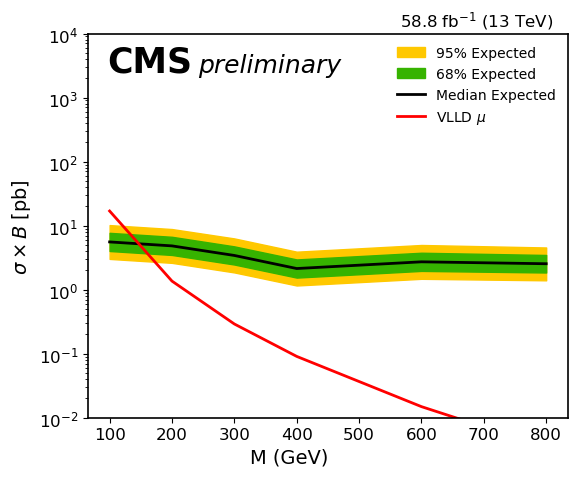

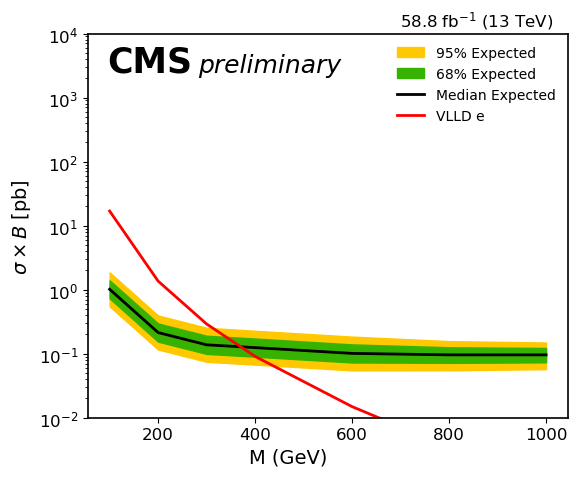

In [14]:
# Set global font settings
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 10,
    'legend.frameon': False,
    'figure.figsize': (6, 5),
    'axes.grid': False,
})

def plot_sigmaB_limits(model_prefix):
    # Filter results for the specified model prefix
    model_results = {key: value for key, value in sigmaB_limit.items() if key.startswith(model_prefix)}
    
    # Extract and sort data by mass
    sorted_models = sorted(model_results.keys(), key=lambda k: int(k.split("_")[-1].replace("M", "")))
    masses = [int(model.split("_")[-1].replace("M", "")) for model in sorted_models]
    observed_limits = [model_results[model]['Observed Limit (sigma_B)'] for model in sorted_models]
    expected_limits = [model_results[model]['Expected Limit (50%) (sigma_B)'] for model in sorted_models]
    expected_1sigma_up = [model_results[model]['Expected Limits (1 sigma)']['up'] for model in sorted_models]
    expected_1sigma_down = [model_results[model]['Expected Limits (1 sigma)']['down'] for model in sorted_models]
    expected_2sigma_up = [model_results[model]['Expected Limits (2 sigma)']['up'] for model in sorted_models]
    expected_2sigma_down = [model_results[model]['Expected Limits (2 sigma)']['down'] for model in sorted_models]
    theory = [model_results[model].get('Theory', 0) for model in sorted_models]  # Add 'Theory' if present

    fig, ax = plt.subplots()
    
    ax.fill_between(masses, expected_2sigma_down, expected_2sigma_up, color='#ffc800', alpha=1.0, label='95% Expected')
    ax.fill_between(masses, expected_1sigma_down, expected_1sigma_up, color='#36b300', alpha=1.0, label='68% Expected')
    ax.plot(masses, expected_limits, 'k-', linewidth=2, label='Median Expected')
    #ax.plot(masses, observed_limits, 'k-', marker='o', linewidth=2, label='Observed')
    ax.plot(masses, theory, 'r-', linewidth=2, label=model_prefix.replace('_', ' ').replace('ele', 'e').replace('mu', r'$\mu$'))
    
    ax.set_xlabel('M (GeV)', fontsize=14, horizontalalignment='right')
    ax.set_ylabel(r'$\sigma \times B$ [pb]', fontsize=14)
    ax.set_ylim(10E-3, 10E3)
    ax.set_yscale('log')
    # ax.set_title(f'{model_prefix} Limits', fontsize=16)
    
    ax.legend(fontsize=10, frameon=False)
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Make the figure box bolder
    for spine in ax.spines.values(): spine.set_linewidth(1.2)

    ax.text(0.04, 0.90, 'CMS', transform=ax.transAxes, fontsize=25, fontweight='bold')
    ax.text(0.23, 0.90, 'preliminary', transform=ax.transAxes, fontsize=18, fontstyle='italic')
    ax.text(0.65, 1.02, '58.8 fb$^{-1}$ (13 TeV)', transform=ax.transAxes, fontsize=12)

    fig.tight_layout()
    plt.savefig('demo.png', dpi=300)
    plt.show()

# Example usage
plot_sigmaB_limits("VLLD_mu")
plot_sigmaB_limits("VLLD_ele")

Preliminary limit calculation. Setup is working, but needs improvement.
Things to do:
- Right now all the backgrounds are combined into one number. (Each bin has only one type of background). More types must be included.
- Somehow signal sigma*B is flat after a certain mass (needs debugging)
- Expected limit grows with mass (unexpected, needs debugging)
- SR is not optimized for maximum S/sqrt{B}
- None of the backgrounds are checked. (Only QCD normalization is done so far). 